#Importing libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import nltk

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

import sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay,roc_auc_score,confusion_matrix
from sklearn.naive_bayes import MultinomialNB

In [4]:
data = files.upload()

Saving SMSspam.csv to SMSspam.csv


FileNotFoundError: ignored

In [6]:
df = pd.read_csv("SMSspam.csv",encoding="utf-8")
df

,Class,input Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will √º b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [7]:
df.head()

,Class,input Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Target Encoding
df['spam'] = df['Class'].map( {'spam': 1, 'ham': 0} ).astype(int)

In [9]:
# Added length of each string
df['length'] = df['input Text'].apply(len)

In [10]:
# Renaming input column
df.rename(columns={'input Text': 'text'}, inplace=True)

In [11]:
# drop unnecessary column
df.drop('Class', axis=1, inplace=True)

In [12]:
df.head()

,text,spam,length
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


Data Preprocessing
1. Remove Punctuation and Stopwords
Punctuation can provide grammatical context to a sentence which supports our understanding. But for our vectorizer which counts the number of words and not the context, it does not add value, so we remove all special characters.

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Stopwords are common words that will likely appear in any text. They don’t tell us much about our data so we remove them.

In [15]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [16]:
from nltk.corpus import stopwords
stopwords.words("english")[10:15]

["you've", "you'll", "you'd", 'your', 'yours']

With the above lists for punctuation characters and stop words, we define a function to remove these from the text. This function will also convert all text to lowercase.

Tokenizing separates text into units such as sentences or words. It gives structure to previously unstructured text.

In [17]:
# Preprocessing steps
def remove_punctuation_and_stopwords(message):
    # remove punctuation
    message_without_punc = [ch for ch in message if ch not in string.punctuation]
    
    # tokenize
    message_without_punc = "".join(message_without_punc).split()
    
    # remove stopword
    message_without_punc_stopwords = \
        [word.lower() for word in message_without_punc if word.lower() not in stopwords.words("english")]
        
    return message_without_punc_stopwords

In [18]:
df['clean'] = df['text'].apply(remove_punctuation_and_stopwords)

In [19]:
df.head()


,text,spam,length,clean
0,"Go until jurong point, crazy.. Available only ...",0,111,"[go, jurong, point, crazy, available, bugis, n..."
1,Ok lar... Joking wif u oni...,0,29,"[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,0,49,"[u, dun, say, early, hor, u, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...",0,61,"[nah, dont, think, goes, usf, lives, around, t..."


#2. Stemming
Stemming helps reduce a word to its stem form. It often makes sense to treat related words in the same way. It removes suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach. It reduces the corpus of words but often the actual words get neglected.

In [20]:
ps = nltk.PorterStemmer()

def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

In [21]:
df['stemmed'] = df['clean'].apply(stemming)
df.head()

,text,spam,length,clean,stemmed
0,"Go until jurong point, crazy.. Available only ...",0,111,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,Ok lar... Joking wif u oni...,0,29,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,0,49,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,"Nah I don't think he goes to usf, he lives aro...",0,61,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."


In [22]:
# Creating a dataframe for stemmed words
df_stem =  pd.DataFrame(df, columns = ['stemmed','spam'])

In [23]:
df_stem['stem'] = [' '.join(map(str, l)) for l in df['stemmed']]

In [24]:
# drop unnecessary column
df_stem.drop('stemmed', axis=1, inplace=True)

In [25]:
df_stem.head()

,spam,stem
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah dont think goe usf live around though


#Train Test Split using stemmed data

In [26]:
# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    df_stem['stem'],
    df_stem['spam'],
    random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4180 4180
1394 1394


In [27]:
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [28]:
# Create a document-term matrix from train and test sets
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [29]:
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

# Create a document-term matrix from train and test sets
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

#Support Vector Classifier

In [30]:
from sklearn.svm import SVC

In [31]:
clf = SVC(probability=True)#max_depth=2, random_state=0

In [32]:
clf.fit(X_train_dtm, y_train)

SVC(probability=True)

In [33]:
# Make class and probability predictions
y_pred_class = clf.predict(X_test_dtm)

In [34]:
y_pred_prob = clf.predict_proba(X_test_dtm)[:, 1]

Accuracy score : 0.98
Recall score : 0.93
Precision score : 1.00
F1 score : 0.93
ROC_AUC Score : 0.98


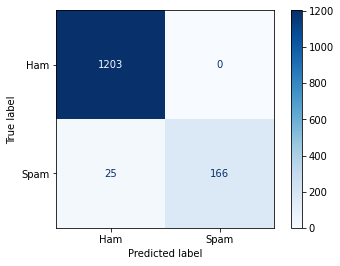

In [35]:
# calculate accuracy of class predictions
print("Accuracy score : {:.2f}".format(accuracy_score(y_test,y_pred_class)))

# calculate recall of class predictions
print("Recall score : {:.2f}".format(recall_score(y_test,y_pred_class,average='macro',zero_division=True)))

# calculate precision of class predictions
print("Precision score : {:.2f}".format(precision_score(y_test,y_pred_class,zero_division = True)))

# calculate f1 score of class predictions
print("F1 score : {:.2f}".format(f1_score(y_test,y_pred_class,zero_division=True)))

# calculate ROC_AUC score of class predictions
print("ROC_AUC Score : {:.2f}".format(roc_auc_score(y_test,y_pred_prob)))

# Create confusion matrix
dtcm = metrics.confusion_matrix(y_test, y_pred_class)
dis = ConfusionMatrixDisplay(dtcm,display_labels=["Ham","Spam"])
dis.plot(cmap=plt.cm.Blues)
plt.show()

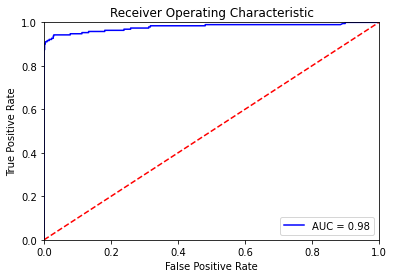

In [36]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()